In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, argparse
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(filename, output):

    f = h5py.File(filename, 'r')
    nrx = f.attrs['nrx']

    for rx in range(1, nrx + 1):
        path = '/rxs/rx' + str(rx) + '/'
        availableoutputs = list(f[path].keys())
        outputdata = f[path + '/' + output]  
        return outputdata, f.attrs['dt']

if __name__ == "__main__":
    
    class args:
        pass

    args.outputfile = 'cylinder_Bscan_2D_merged.out'
    args.output = 'Ez'

    outputdata, dt = make_plot(args.outputfile, args.output)

In [3]:
rc = outputdata.shape
data = np.array(outputdata)

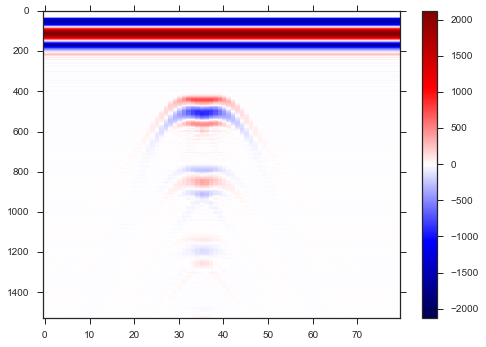

In [4]:
with sns.axes_style("ticks"):
    plt.imshow(data,interpolation='nearest', aspect='auto', cmap='seismic', vmin=-np.amax(np.abs(outputdata)), vmax=np.amax(np.abs(outputdata)))
    plt.colorbar()

(-2500, 2500)

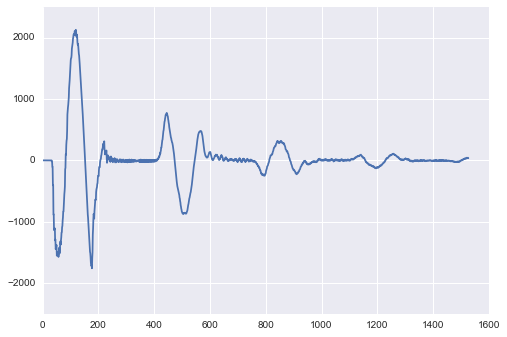

In [5]:
plot(data[:,34])
plt.ylim(-2500,2500)

In [6]:
groundClearData = []
for i in range(rc[0]):
    if len(set(data[i,:]))==1:
        groundClearData.append([0]*int(rc[1]))
    else:
        groundClearData.append(data[i,:])

groundClearData = np.array(groundClearData).astype(float32)

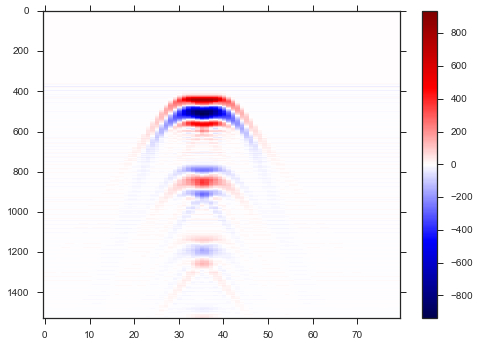

In [7]:
with sns.axes_style("ticks"):
    plt.imshow(groundClearData,interpolation='nearest', aspect='auto', cmap='seismic', vmin=-np.amax(np.abs(groundClearData)), vmax=np.amax(np.abs(groundClearData)))
    plt.colorbar()

In [8]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=rc[1],whiten=True)
pca.fit(groundClearData)
eigenData = pca.transform(groundClearData)

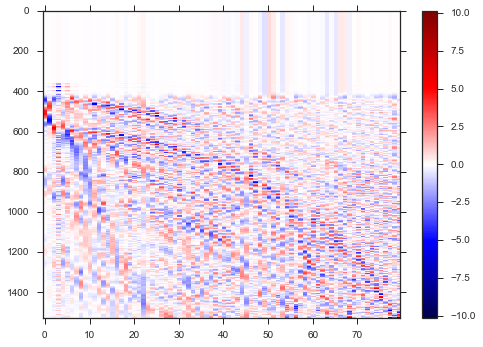

In [9]:
with sns.axes_style("ticks"):
    plt.imshow(eigenData,interpolation='nearest', aspect='auto', cmap='seismic', vmin=-np.amax(np.abs(eigenData)), vmax=np.amax(np.abs(eigenData)))
    plt.colorbar()

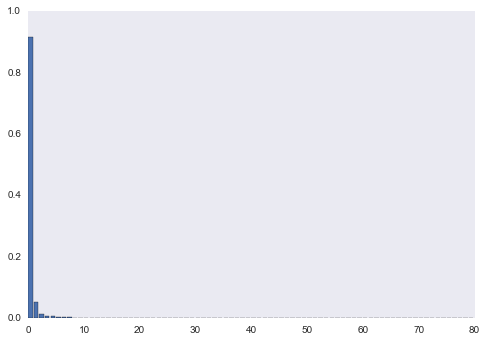

In [10]:
eigenVariance = pca.explained_variance_ratio_
xAxis = [i for i in range(len(eigenVariance))]

plt.bar(xAxis, eigenVariance)
plt.grid()

In [11]:
highestEigenData = np.array(eigenData)
for i in range(1,rc[1]):
    highestEigenData[:,i] = [0]*rc[0]

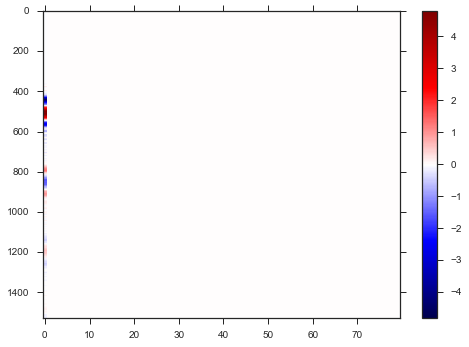

In [12]:
with sns.axes_style("ticks"):
    plt.imshow(highestEigenData,interpolation='nearest', aspect='auto', cmap='seismic', vmin=-np.amax(np.abs(highestEigenData)), vmax=np.amax(np.abs(highestEigenData)))
    plt.colorbar()

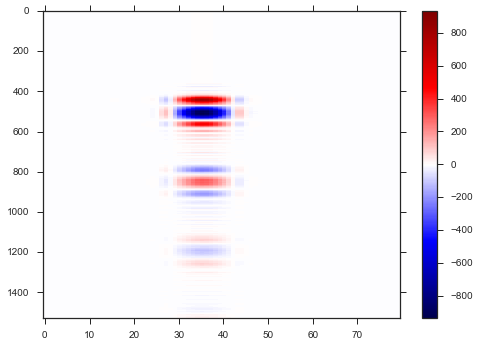

In [13]:
pcaData = np.array(pca.inverse_transform(highestEigenData))

with sns.axes_style("ticks"):
    plt.imshow(pcaData,interpolation='nearest', aspect='auto', cmap='seismic', vmin=-np.amax(np.abs(pcaData)), vmax=np.amax(np.abs(pcaData)))
    plt.colorbar()

(-2500, 2500)

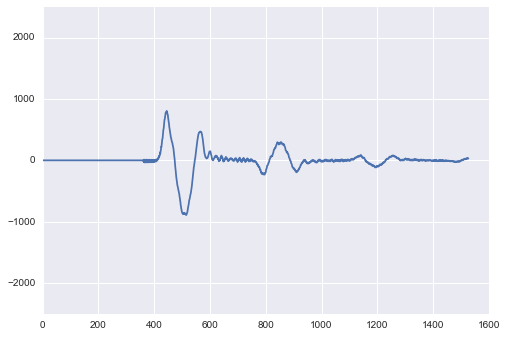

In [14]:
plot(pcaData[:,34])
plt.ylim(-2500,2500)

In [15]:
binaryData = np.zeros(rc)

for i in range(rc[0]):
    for j in range(rc[1]):
        if pcaData[i,j] > 100:
            binaryData[i,j] = 0
        if pcaData[i,j] < -50:
            binaryData[i,j] = 1

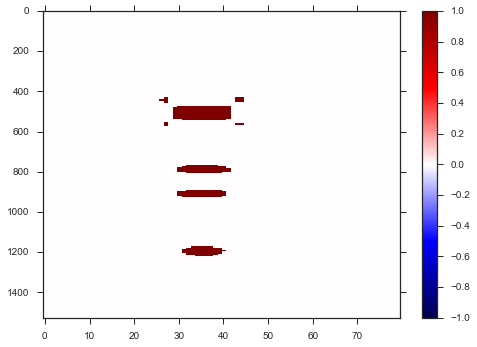

In [16]:
with sns.axes_style("ticks"):
    plt.imshow(binaryData,interpolation='nearest', aspect='auto', cmap='seismic',vmin=-np.amax(np.abs(binaryData)), vmax=np.amax(np.abs(binaryData)))
    plt.colorbar()

In [17]:
import cv2

kernel = np.ones((5,5),np.uint8)
erodeData = cv2.erode(binaryData,kernel,iterations = 1)

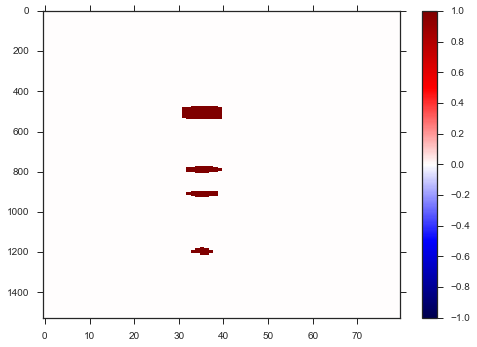

In [18]:
with sns.axes_style("ticks"):
    plt.imshow(erodeData,interpolation='nearest', aspect='auto', cmap='seismic',vmin=-np.amax(np.abs(erodeData)), vmax=np.amax(np.abs(erodeData)))
    plt.colorbar()

In [19]:
def maxlist(a):
    b = []
    sum1 = 0
    for i in range(len(a)):
        sum1 = sum1 +a[i]
        if a[i] ==0:
            sum1 = 0
        b.append(sum1)
    
    x = b.index(max(b))
    c = list(np.zeros(len(a)).astype(int))
    for i in range(max(b)):
        c[x] = 1
        x-=1
    return c

In [20]:
noiseReduceData = np.zeros(rc)

for i in range(rc[1]):
    noiseReduceData[:,i] = maxlist(list(erodeData[:,i].astype(int)))

noiseReduceData = noiseReduceData.astype(float32)

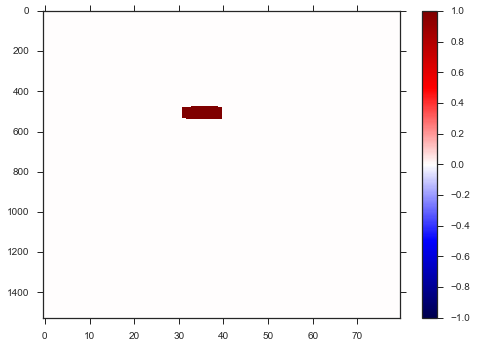

In [21]:
with sns.axes_style("ticks"):
    plt.imshow(noiseReduceData,interpolation='nearest', aspect='auto', cmap='seismic', vmin=-np.amax(np.abs(noiseReduceData)), vmax=np.amax(np.abs(noiseReduceData)))
    plt.colorbar()

(-2500, 2500)

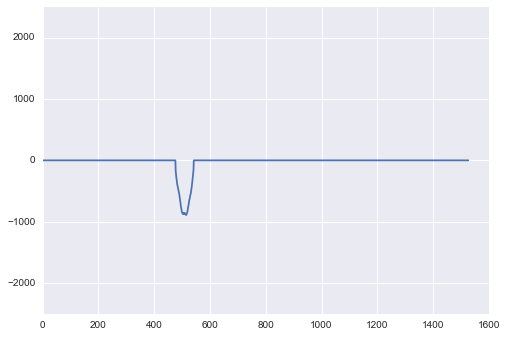

In [22]:
noiseReduceDataRGB = np.zeros(rc)
for i in range(rc[0]):
    for j in range(rc[1]):
        if noiseReduceData[i,j] ==1:
            noiseReduceDataRGB[i,j] = pcaData[i,j]

plot(noiseReduceDataRGB[:,34])
plt.ylim(-2500,2500)

In [23]:
_,contours,hierarchy = cv2.findContours(noiseReduceData.astype(np.uint8), 1, 2)

finList = []

for i in range(len(contours)):
    print('{} landmine details:'.format(i+1))
    cnt = contours[i]
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    print('\nCentroid of the detected landmine is located at,\n', cx, cy)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    print('\nThe corners of the landmine are approximately located at,\n', box)
    finList.append([cx,cy,box])

1 landmine details:

Centroid of the detected landmine is located at,
 35 509

The corners of the landmine are approximately located at,
 [[ 31 541]
 [ 31 477]
 [ 39 477]
 [ 39 541]]


In [24]:
#title: B-scan from a metal cylinder buried in a dielectric half-space
#domain: 6.00 2.00 0.002
#dx_dy_dz: 0.002 0.002 0.002
#time_window: 7.2e-9
#pml_cells: 10 10 0 10 10 0

#material: 6 0 1 0 half_space

#waveform: sine 1 1.5e9 my_ricker
#hertzian_dipole: z 2.3 1.80 0 my_ricker
#rx: 2.35 1.80 0

#src_steps: 0.023 0 0
#rx_steps: 0.023 0 0

#box: 0 0 0 6.00 1.750 0.002 half_space
#box: 3.00 1.55 0 3.20 1.65 0.002 pec

In [25]:
er = 6
dipoleDistance = 1.8
groundDistance = 0.05
freeSpaceDistance = 2 - dipoleDistance
s1 = 2.3
s2 = 2.35
step = 0.023

In [26]:
def time2spatial(t,groundDistance,er,dipoleDistance,freeSpaceDistance):
    c = 3*10**8
    t = t/2.0302959
    x1 = groundDistance/c
    z = t - x1
    z1 = (z*c)/np.sqrt(er)
    return dipoleDistance - z1+groundDistance - freeSpaceDistance

def scan2spatial(x,s1,s2,step):
    return np.mean([s1,s2]) + step*x

In [27]:
def centroid(cx,cy,dt):
    er = 6
    dipoleDistance = 1.8
    groundDistance = 0.1
    s1 = 2.3
    s2 = 2.34
    step = 0.023
    freeSpaceDistance = 2 - dipoleDistance
    cx = scan2spatial(cx,s1,s2,step)
    cy = time2spatial(cy*dt,groundDistance,er,dipoleDistance,freeSpaceDistance)
    return cx,cy

In [28]:
def corners(box,dt):
    spatialBox = []
    for i in box:
        spatialBox.append(centroid(i[0],i[1],dt))
    return spatialBox

In [29]:
for i in finList:
    box = np.array(corners(i[2],dt))
    cxy = centroid(i[0],i[1],dt)
    print('The centroid is located at, \n {}'.format(cxy))
    print('The coreners are at, \n {}'.format(box))

The centroid is located at, 
 (3.125, 1.5959815429637292)
The coreners are at, 
 [[ 3.033       1.58687548]
 [ 3.033       1.6050876 ]
 [ 3.217       1.6050876 ]
 [ 3.217       1.58687548]]


In [30]:
#box: 3.00 1.55 0 3.20 1.65 0.002 pvc

In [31]:
xScan = []
for i in finList:
    xScan.append(i[0])

In [32]:
def checkMaterial(a):
    b = []
    count = 0
    sum1 = 0
    for i in range(len(a)):
        sum1 = sum1 +a[i]
        if a[i] ==0:
            sum1 = 0
        b.append(sum1)
    
    for i in range(len(b)-1):
        if b[i+1]==1:
            if b[i]==0:
                count+=1
            
    return count

In [33]:
l = 1
for i in xScan:
    j = checkMaterial(erodeData[:,i])
    if j>=3:
        print('Landmine {} could be metal'.format(l))
    else:
        print('Landmine {} could be plastic'.format(l))
    l+=1

Landmine 1 could be metal
